In [1]:
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates    import DayLocator, MonthLocator, DateFormatter
import glob
import pickle, sys, os, json
import subprocess
import matplotlib.pyplot as plt

# Importing custom utility functions
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux

#///////////////////////////////////////////////
# EXPORT ALL PARAMETERS
#///////////////////////////////////////////////
# The configuration file path is fixed for the scrips
fname_config_scaling = os.path.join("config", "config_scaling_parameters.json")

# Code to read it
with open(fname_config_scaling, "r") as json_file:
    configuration_dictionary = json.load(json_file)

# Now we wxtract all the variables with the same name as in the dictionary
source_name = configuration_dictionary["source_name"]
for superkey in ["fit_parameters", "paths"]:
    for key, value in configuration_dictionary[superkey].items():
        globals()[key] = value
#///////////////////////////////////////////////

In [2]:
# Root path of this script
root = os.getcwd() + "/"
# We need to create also a folder to store the slurm outputs
root_slurm = root + "objects/output_slurm/"

dict_colors = {'CANCELLED':'gray', 'COMPLETED':'g', 'FAILED':'r', 'RUNNING':'b', 'COMPLETING':'gold', 'TIMEOUT':'k'}
dict_symbol = {'CANCELLED':'90', 'COMPLETED':'92', 'FAILED':'91', 'RUNNING':'94', 'COMPLETING':'93', 'TIMEOUT':'91'}

In [10]:
total_slurm_outputs = glob.glob(root_slurm + "*.out")
total_job_ids = np.array([int(f.split("-")[-1].split(".")[0]) for f in total_slurm_outputs])

print(f"Found {len(total_slurm_outputs)} slurm output files.")

total_job_names,       total_job_states     = [], []
total_job_dependency,  total_job_run_time   = [], []
total_job_submit_time, total_job_start_time = [], []
for id in total_job_ids:

    ###################################%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    output = subprocess.check_output(f"scontrol show jobid -dd {id}", shell=True)
    output_string = output.decode("utf-8")
    
    output_dict = {}
    list_output = output_string.split(" ")
    for o in list_output:
        o = o.replace("\n", " ")
        if o != "":
            try:
                key, value = o.split("=")
                output_dict[key] = value
            except:
                pass
    
    total_job_names.append(output_dict["JobName"])
    total_job_states.append(output_dict["JobState"])
    total_job_dependency.append(False if output_dict["Dependency"] == "(null) " else True)
    total_job_run_time.append((datetime.fromisoformat(f"0001-01-01 {output_dict['RunTime']}") - datetime.fromisoformat("0001-01-01 00:00:00")))
    total_job_submit_time.append(datetime.fromisoformat(output_dict['SubmitTime']))
    total_job_start_time.append(datetime.fromisoformat(output_dict['StartTime']))

total_job_stop_time   = np.array(total_job_start_time) + np.array(total_job_run_time)

_, total_slurm_outputs  = aux.sort_based(np.array(total_slurm_outputs), total_job_stop_time)
_, total_job_ids        = aux.sort_based(np.array(total_job_ids), total_job_stop_time)
_, total_job_names      = aux.sort_based(np.array(total_job_names), total_job_stop_time)
_, total_job_states     = aux.sort_based(np.array(total_job_states), total_job_stop_time)
_, total_job_dependency = aux.sort_based(np.array(total_job_dependency), total_job_stop_time)
_, total_job_run_time   = aux.sort_based(np.array(total_job_run_time), total_job_stop_time)
_, total_job_start_time  = aux.sort_based(np.array(total_job_start_time), total_job_stop_time)
total_job_stop_time, total_job_submit_time = aux.sort_based(np.array(total_job_submit_time), total_job_stop_time)


Found 2499 slurm output files.


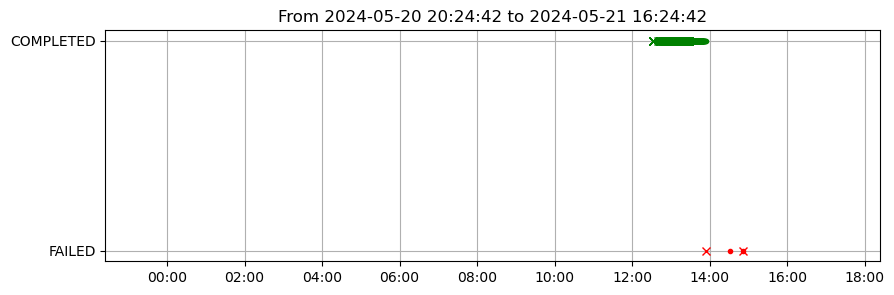

In [11]:
plot_timespan  = timedelta(hours=20)
plot_stop_time = datetime.now()
phase_timezone = timedelta(hours=2)

start_time = plot_stop_time - plot_timespan 
stop_time  = plot_stop_time


mask_time = np.array([t > start_time and t < stop_time for t in total_job_submit_time])
mask_running    = (mask_time & [s == "RUNNING" for s in total_job_states])
mask_failed     = (mask_time & [s == "FAILED" for s in total_job_states])
mask_cancelled  = (mask_time & [s == "CANCELLED" for s in total_job_states])
mask_completed  = (mask_time & [s == "COMPLETED" for s in total_job_states])
mask_completing = (mask_time & [s == "COMPLETING" for s in total_job_states])


fig, ax = plt.subplots(figsize=(10, 3))


for mask, key in zip([mask_cancelled, mask_failed, mask_running, mask_completed], ["CANCELLED", "FAILED", "RUNNING", "COMPLETED", "COMPLETING"]):
    ax.plot(total_job_stop_time[mask] + phase_timezone, total_job_states[mask], 
            marker=".", ls="", color=dict_colors[key])
    ax.plot(total_job_start_time[mask] + phase_timezone, total_job_states[mask], 
            marker="x", ls="", color=dict_colors[key])

ax.set_xlim(start_time + phase_timezone, stop_time + phase_timezone)

ax.set_title(f"From {str(start_time).split('.')[0]} to {str(stop_time).split('.')[0]}")
ax.grid()
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

plt.show()

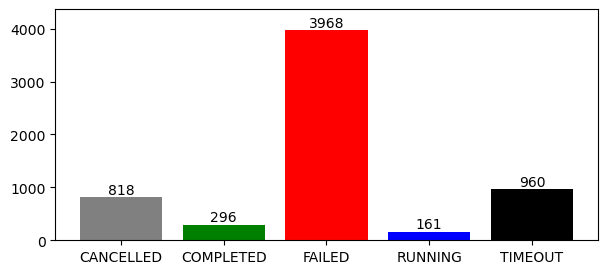

In [245]:
different_states, counts_states = np.unique(total_job_states, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 3))

bars = ax.bar(different_states, counts_states, color=[dict_colors[k] for k in different_states])
ax.bar_label(bars)
ax.set_ylim(0, max(counts_states) * 1.1)
# ax.grid()

plt.show()

In [247]:
!scancel -u juan.jimenez

In [246]:
for i in range(len(total_job_submit_time))[:]:
    ii = len(total_job_submit_time) - i - 1
    st = total_job_states[ii]

    string_file = f"\033[{dict_symbol[st]}m\n{str(total_job_submit_time[ii])} job {total_job_ids[ii]}: {st}"
    string_file = string_file + f"- RunTime {total_job_run_time[ii]} \n{total_slurm_outputs[ii]}\033"
    print(string_file)


2024-05-15 12:29:50 job 35269583: RUNNING- RunTime 0:09:20 
/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing_srunwise/objects/output_slurm/slurm_init-35269583.out

2024-05-15 12:29:46 job 35269555: RUNNING- RunTime 0:09:47 
/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing_srunwise/objects/output_slurm/slurm_init-35269555.out

2024-05-15 12:29:31 job 35269451: RUNNING- RunTime 0:09:44 
/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing_srunwise/objects/output_slurm/slurm_init-35269451.out

2024-05-15 12:29:41 job 35269525: RUNNING- RunTime 0:09:43 
/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing_srunwise/objects/output_slurm/slurm_init-35269525.out

2024-05-15 12:29:32 job 35269460: RUNNING- RunTime 0:09:45 
/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing_srunwise/objects/output_slurm/slurm_init-35269460.